# Importing Libraries

In [4]:
from fastai.vision.core import *
from fastai.vision.data import *
from fastai.vision.all import *
from fastai.vision import *
import fastai

import matplotlib.pyplot as plt

In [5]:
# Making sure we are using correct version of FastAI
fastai.__version__

'2.0.0'

# Making the Dataloader

In this section, we will load all our dataset to put into the unet model

In [6]:
# The function to input the image name and get path of corresponding mask image

def label_func(x): return f'dataset/train_gt/{x.stem}.png'

In [9]:
# Creating batches of images with their correspoding mask 

src = SegmentationDataLoaders.from_label_func("",  # the path of the folders 
                                              get_image_files('dataset/train_images'), # get image files in train_images folder
                                              label_func,  # get the correspsong mask
                                              batch_tfms=aug_transforms(do_flip=True, # Data Argumentation
                                                                        flip_vert=True, 
                                                                        max_rotate=360.0, 
                                                                        min_zoom=1.0, max_zoom=5, 
                                                                        max_lighting=0.2, max_warp=0.2, 
                                                                        p_affine=0.75, p_lighting=0.75), 
                                              
                                              codes=np.array(['Background','Water']), # there are two classes, background and water
                                              bs=4,# set batch size to 4
                                              valid_pct=0.05, # seeting 5% of data to validation ( i know it's low!)
                                              num_workers=0, # if on windows, don't change this!
                                              shuffle_train=False)

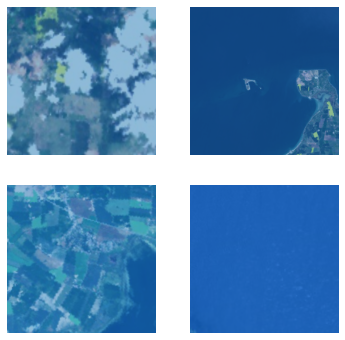

In [10]:
# Swowing a batch of images

src.show_batch(max_n=9, vmin=1, vmax=30)

In [11]:
# Getting one batch of images and labels

x,y = src.one_batch()
x, y

(TensorImage([[[[0.7191, 0.6845, 0.6667,  ..., 1.0000, 1.0000, 1.0000],
           [0.6210, 0.5645, 0.5276,  ..., 1.0000, 1.0000, 1.0000],
           [0.5338, 0.4604, 0.4069,  ..., 0.9976, 0.9987, 1.0000],
           ...,
           [0.2409, 0.2323, 0.2221,  ..., 0.1180, 0.1257, 0.1326],
           [0.2506, 0.2469, 0.2416,  ..., 0.1302, 0.1397, 0.1486],
           [0.2619, 0.2631, 0.2627,  ..., 0.1527, 0.1558, 0.1704]],
 
          [[0.7690, 0.7345, 0.7175,  ..., 0.9995, 0.9981, 0.9969],
           [0.6739, 0.6170, 0.5806,  ..., 0.9993, 0.9964, 0.9945],
           [0.5918, 0.5175, 0.4638,  ..., 0.9967, 0.9947, 0.9918],
           ...,
           [0.3200, 0.3085, 0.2953,  ..., 0.2136, 0.2186, 0.2222],
           [0.3293, 0.3226, 0.3144,  ..., 0.2207, 0.2292, 0.2365],
           [0.3401, 0.3384, 0.3351,  ..., 0.2345, 0.2400, 0.2556]],
 
          [[0.8112, 0.7753, 0.7575,  ..., 0.9622, 0.9691, 0.9764],
           [0.7280, 0.6692, 0.6323,  ..., 0.9661, 0.9743, 0.9825],
           [0.6472,

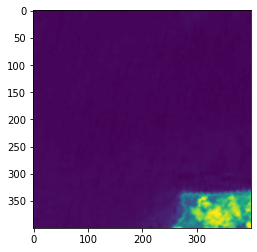

In [12]:
# Setting the first image from the X

plt.imshow(x.cpu().numpy()[1,0,:,:])

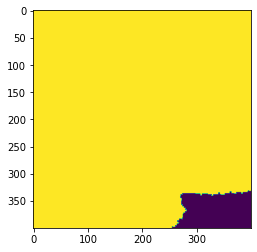

In [13]:
# Seiing the first label from Y

plt.imshow(y.cpu().numpy()[1,:,:])

# Making the Model

In [14]:
# Using a Unet model for our image segmentation task and using mixed precision for faster training. 

learn = unet_learner(src, xresnet34_deep)#.to_fp16()

SuggestedLRs(lr_min=3.311311302240938e-05, lr_steep=0.00015848931798245758)

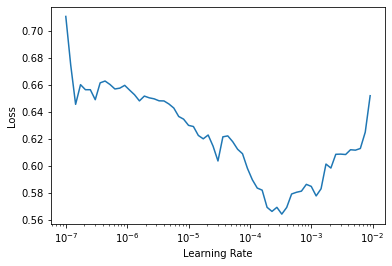

In [15]:
# Finding a good learning rate

learn.lr_find()

In [18]:
# Setting up WandB callback

import wandb
from fastai.callback.wandb import *

# 1. Start a new run
wandb.init(project="water segmentation", name  ='water segmentation reduce on plateau')


wandb: Wandb version 0.10.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Run: https://app.wandb.ai/shubhamai/water%20segmentation/runs/37begsgc

In [19]:
# Using One Cycle Learning Rate Policy for training  

learn.fit_one_cycle(10, cbs=[WandbCallback(), 
                            SaveModelCallback(), # saving model with every new lowest val loss 
                            ReduceLROnPlateau(monitor='valid_loss', min_delta=0.2, patience=2) # Reduce lr when validation loss stops decreasing
                            ])

C:\Users\Saurabh\anaconda3\lib\site-packages\wandb\compat\tempfile.py:64: UserWarning: Couldn't remove temp directory C:\Users\Saurabh\AppData\Local\Temp\tmpl31vhz84wandb
  _warnings.warn("Couldn't remove temp directory %s" % name)
wandb: Wandb version 0.10.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


epoch,train_loss,valid_loss,time
0,0.416292,0.462053,02:53
1,0.404389,0.397078,02:24
2,0.375557,0.388280,02:25
3,0.330149,0.335812,02:28
4,0.324608,0.311123,02:27
5,0.332172,0.293183,02:28
6,0.270627,0.269419,02:29
7,0.279867,0.259611,02:28
8,0.254201,0.260664,02:28
9,0.261212,0.273971,02:31


Better model found at epoch 0 with valid_loss value: 0.46205273270606995.
Better model found at epoch 1 with valid_loss value: 0.39707767963409424.
Better model found at epoch 2 with valid_loss value: 0.3882797956466675.
Epoch 2: reducing lr to 9.892042885899707e-05


wandb: ERROR Error uploading "config.yaml": CommError, C:\Users\Saurabh\AppData\Local\Temp\tmpobxy3zebwandb\ljybl7oy-config.yaml is an empty file


Better model found at epoch 3 with valid_loss value: 0.3358124792575836.
Better model found at epoch 4 with valid_loss value: 0.3111230432987213.
Epoch 4: reducing lr to 7.505469591871614e-05
Better model found at epoch 5 with valid_loss value: 0.2931833267211914.
Better model found at epoch 6 with valid_loss value: 0.2694188952445984.
Epoch 6: reducing lr to 3.460963282371154e-05
Better model found at epoch 7 with valid_loss value: 0.2596108019351959.


wandb: ERROR Error uploading "config.yaml": CommError, C:\Users\Saurabh\AppData\Local\Temp\tmpobxy3zebwandb\2sry0ryy-config.yaml is an empty file


Epoch 9: reducing lr to 1.0395499791060817e-09


In [20]:
# Saving the model

learn.export()

# Making Predictions

In [23]:
learn = load_learner("export.pkl")

In [24]:
import re
import os
from pathlib import Path
from tqdm import tqdm
import cv2

# A function to sort image name
def num(x):
    return int(re.sub(r"\D", "", x))

# Reading all image name 
file_list = os.listdir("./dataset/test_images")
file_list

# Sorting the image name
x = sorted(file_list, key = num)

# Getting all image path
img_path = []

for i in x:
    i = "./dataset/test_images/" + i
    img_path.append(i)

In [25]:
# Predicting all images

all_pred = []

for i in img_path:
  predictions = learn.predict(i)
  all_pred.append(predictions[1].numpy().flatten())

In [26]:
# Converting all_pred to numpy array

main_array = np.asarray(all_pred)

In [27]:
# Reshaping the array

main_array_flat = np.reshape(main_array,(-1))

In [28]:
# Saving the array to a .npy file

with open("submission_continuous_now.npy", 'wb') as f:
    np.save(f,main_array_flat)